In [0]:
# https://keras.io/
!pip install -q keras
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely
!pip install imgaug
!pip install --upgrade scikit-image

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Lambda, SeparableConv2D
from keras.layers.merge import concatenate
from keras.activations import relu, softmax
from keras.callbacks import *
from imgaug import augmenters as iaa

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as K

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))


Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.15.0)


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls
!unzip -qq "/content/gdrive/My Drive/Datasets/tiny-imagenet-200.zip"
!ls

gdrive	sample_data
gdrive	sample_data  tiny-imagenet-200


In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib  inline
from keras.preprocessing.image import ImageDataGenerator

In [0]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [0]:
# Use Augmentaion parameters as required.
train_datagen = ImageDataGenerator(rescale= 1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(32, 32), color_mode='rgb', 
                                                    batch_size=256, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=256, shuffle=True, seed=42)

Found 10000 images belonging to 200 classes.


In [0]:
input = Input(shape=(None, None, 3))

norm1 = BatchNormalization(name='norm1')(input)
conv1 = Conv2D(32, (3,3), activation='relu', name='conv1', use_bias=False, padding='same')(norm1) # 3 

norm2 = BatchNormalization(name='norm2')(conv1)
conv2 = Conv2D(128, (3,3), activation='relu', name='conv2', use_bias=False, padding='same')(norm2) # 5

skip11 = concatenate([conv1, conv2])

norm3 = BatchNormalization(name='norm3')(skip11)
conv3 = Conv2D(512, (3,3), activation='relu', name='conv3', use_bias=False, padding='same')(norm3) # 7

norm1x1_1 = BatchNormalization(name='norm1x1_1')(conv3)
conv1x1_1 = Conv2D(64, (1,1), activation='relu', name='conv1x1_1', use_bias=False, padding='same')(norm1x1_1) # 18

pool1 = MaxPooling2D(pool_size=(2,2))(conv1x1_1) # 14

norm4 = BatchNormalization(name='norm4')(pool1)
conv4 = Conv2D(64, (5,5), activation='relu', name='conv4', use_bias=False, padding='same')(norm4) # 18

norm5 = BatchNormalization(name='norm5')(conv4)
conv5 = Conv2D(256, (5,5), activation='relu', name='conv5', use_bias=False, padding='same')(norm5) # 22

skip21 = concatenate([conv4, conv5])

norm6 = BatchNormalization(name='norm6')(skip21)
conv6 = Conv2D(1024, (5,5), activation='relu', name='conv6', use_bias=False, padding='same')(norm6) # 26

norm1x1_2 = BatchNormalization(name='norm1x1_2')(conv6)
conv1x1_2 = Conv2D(128, (1,1), activation='relu', name='conv1x1_2', use_bias=False, padding='same')(norm1x1_2) # 26

pool2 = MaxPooling2D(pool_size=(2,2))(conv1x1_2) # 52

norm7 = BatchNormalization(name='norm7')(pool2)
conv7 = Conv2D(128, (5,5), activation='relu', name='conv7', use_bias=False, padding='same')(norm7) # 56

norm8 = BatchNormalization(name='norm8')(conv7)
conv8 = Conv2D(512, (5,5), activation='relu', name='conv8', use_bias=False, padding='same')(norm8) # 60

skip31 = concatenate([conv7, conv8])

norm9 = BatchNormalization(name='norm9')(skip31)
conv9 = SeparableConv2D(2048, (5,5), activation='relu', name='conv9', use_bias=False, padding='same')(norm9) # 64

norm10 = BatchNormalization(name='norm10')(conv9)
conv10 = Conv2D(200, (1,1), activation='relu', name='conv10', use_bias=False, padding='same')(norm10)

pool3 = GlobalAveragePooling2D()(conv10)
output = Activation(softmax)(pool3)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
norm1 (BatchNormalization)      (None, None, None, 3 12          input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 3 864         norm1[0][0]                      
__________________________________________________________________________________________________
norm2 (BatchNormalization)      (None, None, None, 3 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Con

In [0]:
## Create and compile a model and fit it using fit_generator
from keras.callbacks import *

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.fit_generator(train_generator, epochs=5, steps_per_epoch=400, validation_steps=40, validation_data=validation_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
400/400 [==============================] - 542s 1s/step - loss: 4.1463 - acc: 0.1268 - val_loss: 4.6715 - val_acc: 0.0958
Epoch 2/5
400/400 [==============================] - 499s 1s/step - loss: 3.2077 - acc: 0.2688 - val_loss: 4.0671 - val_acc: 0.1390
Epoch 3/5
400/400 [==============================] - 501s 1s/step - loss: 2.7331 - acc: 0.3576 - val_loss: 3.8367 - val_acc: 0.1636
Epoch 4/5
400/400 [==============================] - 497s 1s/step - loss: 2.3405 - acc: 0.4362 - val_loss: 3.6861 - val_acc: 0.1858
Epoch 5/5
400/400 [==============================] - 498s 1s/step - loss: 1.9772 - acc: 0.5126 - val_loss: 3.6432 - val_acc: 0.1911


In [0]:
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
filepath = "/content/gdrive/My Drive/weights/asgn4-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)

model.fit_generator(train_generator, epochs=10, steps_per_epoch=800, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint])

Epoch 1/10
800/800 [==============================] - 3480s 4s/step - loss: 2.2978 - acc: 0.4455 - val_loss: 2.2540 - val_acc: 0.4627

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-epochs:001-val_acc:0.463.hdf5
Epoch 2/10
800/800 [==============================] - 3421s 4s/step - loss: 1.6815 - acc: 0.5800 - val_loss: 2.0964 - val_acc: 0.4937

Epoch 00002: saving model to /content/gdrive/My Drive/weights/asgn4-epochs:002-val_acc:0.494.hdf5
Epoch 3/10
800/800 [==============================] - 3407s 4s/step - loss: 1.2526 - acc: 0.6812 - val_loss: 2.0552 - val_acc: 0.5194

Epoch 00003: saving model to /content/gdrive/My Drive/weights/asgn4-epochs:003-val_acc:0.519.hdf5
Epoch 4/10
800/800 [==============================] - 3391s 4s/step - loss: 0.8700 - acc: 0.7759 - val_loss: 2.0350 - val_acc: 0.5345

Epoch 00004: saving model to /content/gdrive/My Drive/weights/asgn4-epochs:004-val_acc:0.534.hdf5
Epoch 5/10
800/800 [==============================] - 3389s 4s/step 

KeyboardInterrupt: ignored

In [0]:
model.load_weights('/content/gdrive/My Drive/weights/asgn4-epochs:003-val_acc:0.519.hdf5')

In [0]:
from imgaug import augmenters as iaa

seq = iaa.Sometimes(0.5, iaa.SomeOf((0, None), [
    iaa.Fliplr(),
    iaa.GaussianBlur(sigma=(0.0, 1.5)),
    iaa.Multiply((0.5, 1.5)),
    iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.50)),
    iaa.Affine(rotate=(0,30))
], random_order=False))

train_datagen = ImageDataGenerator(rescale= 1./255, preprocessing_function=seq.augment_image)

train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)


Found 100000 images belonging to 200 classes.


In [0]:
from keras.callbacks import *

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

filepath = "/content/gdrive/My Drive/weights/asgn4-augment-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)

model.fit_generator(train_generator, epochs=10, steps_per_epoch=800, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
800/800 [==============================] - 3437s 4s/step - loss: 1.3748 - acc: 0.6558 - val_loss: 2.1519 - val_acc: 0.5069

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:001-val_acc:0.507.hdf5
Epoch 2/10
184/800 [=====>........................] - ETA: 42:44 - loss: 1.0257 - acc: 0.7417

KeyboardInterrupt: ignored

In [0]:
seq = iaa.Sometimes(0.5, iaa.SomeOf((1, None), [
    iaa.Fliplr(),
    iaa.GaussianBlur(sigma=(0.0, 1.5)),
    iaa.Multiply((0.5, 1.5)),
    iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.05)),
    iaa.Affine(rotate=(-30,30))
], random_order=False))

train_datagen = ImageDataGenerator(rescale= 1./255, preprocessing_function=seq.augment_image)

train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
filepath = "/content/gdrive/My Drive/weights/asgn4-augment-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)

model.fit_generator(train_generator, epochs=5, steps_per_epoch=800, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint])

Epoch 1/5
800/800 [==============================] - 3386s 4s/step - loss: 1.0480 - acc: 0.7375 - val_loss: 2.2819 - val_acc: 0.5070

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:001-val_acc:0.507.hdf5
Epoch 2/5
800/800 [==============================] - 3378s 4s/step - loss: 0.8786 - acc: 0.7769 - val_loss: 2.2470 - val_acc: 0.5116

Epoch 00002: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:002-val_acc:0.512.hdf5
Epoch 3/5
800/800 [==============================] - 3376s 4s/step - loss: 0.7181 - acc: 0.8162 - val_loss: 2.2678 - val_acc: 0.5123

Epoch 00003: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:003-val_acc:0.512.hdf5
Epoch 4/5
  2/800 [..............................] - ETA: 55:08 - loss: 0.4176 - acc: 0.8984

KeyboardInterrupt: ignored

In [0]:
seq = iaa.Sometimes(0.7, iaa.SomeOf((2, None), [
    iaa.Fliplr(),
    iaa.GaussianBlur(sigma=(0.01, 1.5)),
    iaa.Multiply((0.5, 1.5)),
    iaa.CoarseDropout((0.01, 0.05), size_percent=(0.02, 0.05)),
    iaa.Affine(rotate=(-30,30))
], random_order=False))

train_datagen = ImageDataGenerator(rescale= 1./255, preprocessing_function=seq.augment_image)

train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
filepath = "/content/gdrive/My Drive/weights/asgn4-augment-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)

model.fit_generator(train_generator, epochs=5, steps_per_epoch=800, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint])

Epoch 1/5
800/800 [==============================] - 3380s 4s/step - loss: 0.9995 - acc: 0.7367 - val_loss: 2.4656 - val_acc: 0.4995

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:001-val_acc:0.499.hdf5
Epoch 2/5
800/800 [==============================] - 3375s 4s/step - loss: 0.8090 - acc: 0.7861 - val_loss: 2.3791 - val_acc: 0.5189

Epoch 00002: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:002-val_acc:0.519.hdf5
Epoch 3/5
800/800 [==============================] - 3375s 4s/step - loss: 0.7111 - acc: 0.8109 - val_loss: 2.4221 - val_acc: 0.5103

Epoch 00003: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:003-val_acc:0.510.hdf5
Epoch 4/5
 59/800 [=>............................] - ETA: 51:15 - loss: 0.6269 - acc: 0.8304

KeyboardInterrupt: ignored

In [0]:
seq = iaa.Sometimes(0.7, iaa.SomeOf((3, None), [
    iaa.AdditiveGaussianNoise(scale=(0.02*255, 0.10*255)),
    iaa.Fliplr(),
    iaa.GaussianBlur(sigma=(0.01, 1.5)),
    iaa.Multiply((0.5, 1.5)),
    iaa.CoarseDropout((0.01, 0.05), size_percent=(0.02, 0.05)),
    iaa.Affine(rotate=(-30,30))
], random_order=True))

train_datagen = ImageDataGenerator(rescale= 1./255, preprocessing_function=seq.augment_image)

train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
filepath = "/content/gdrive/My Drive/weights/asgn4-augment-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-6)
model.fit_generator(train_generator, epochs=10, steps_per_epoch=400, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint, reduce_lr])

Epoch 1/10
400/400 [==============================] - 1722s 4s/step - loss: 1.1488 - acc: 0.7016 - val_loss: 2.5455 - val_acc: 0.4882

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:001-val_acc:0.488.hdf5
Epoch 2/10
400/400 [==============================] - 1717s 4s/step - loss: 1.1417 - acc: 0.7044 - val_loss: 2.5908 - val_acc: 0.4931

Epoch 00002: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:002-val_acc:0.493.hdf5
Epoch 3/10
400/400 [==============================] - 1720s 4s/step - loss: 0.9772 - acc: 0.7447 - val_loss: 2.5670 - val_acc: 0.4944

Epoch 00003: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:003-val_acc:0.494.hdf5
Epoch 4/10
400/400 [==============================] - 1716s 4s/step - loss: 0.8376 - acc: 0.7840 - val_loss: 2.2846 - val_acc: 0.5358

Epoch 00004: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:004-val_acc:0.536.hdf5
Epoch 5/10
400/400 [================

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-dvqjrwx8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ibcfzlfm/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
import keras_contrib
from keras_contrib.callbacks.cyclical_learning_rate import CyclicLR

In [0]:
model.load_weights('/content/gdrive/My Drive/weights/asgn4-augment-epochs:007-val_acc:0.548.hdf5')

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, momentum=0.7, nesterov=True),
              metrics=['accuracy'])

In [0]:
from imgaug import augmenters as iaa

seq = iaa.Sometimes(0.8, iaa.SomeOf((3, None), [
    iaa.AdditiveGaussianNoise(scale=(0.02*255, 0.10*255)),
    iaa.Fliplr(),
    iaa.GaussianBlur(sigma=(0.01, 1.5)),
    iaa.Multiply((0.5, 1.5)),
    iaa.CoarseDropout((0.01, 0.05), size_percent=(0.02, 0.05)),
    iaa.Affine(rotate=(-30,30))
], random_order=True))

train_datagen = ImageDataGenerator(rescale= 1./255, preprocessing_function=seq.augment_image)

train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(32, 32), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
filepath = "/content/gdrive/My Drive/weights/asgn4-augment-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-6)
model.fit_generator(train_generator, epochs=10, steps_per_epoch=400, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint, reduce_lr])

Epoch 1/10
400/400 [==============================] - 323s 808ms/step - loss: 4.3715 - acc: 0.2121 - val_loss: 3.4825 - val_acc: 0.3732

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:001-val_acc:0.373.hdf5
Epoch 2/10
400/400 [==============================] - 298s 745ms/step - loss: 3.6290 - acc: 0.2450 - val_loss: 3.5384 - val_acc: 0.3684

Epoch 00002: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:002-val_acc:0.368.hdf5
Epoch 3/10
400/400 [==============================] - 297s 742ms/step - loss: 3.3065 - acc: 0.2849 - val_loss: 3.3931 - val_acc: 0.3616

Epoch 00003: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:003-val_acc:0.362.hdf5
Epoch 4/10
400/400 [==============================] - 296s 740ms/step - loss: 3.1875 - acc: 0.3013 - val_loss: 3.1913 - val_acc: 0.3494

Epoch 00004: saving model to /content/gdrive/My Drive/weights/asgn4-augment-epochs:004-val_acc:0.349.hdf5
Epoch 5/10
400/400 [========

In [0]:
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(48, 48), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, momentum=0.7, nesterov=True),
              metrics=['accuracy'])

filepath = "/content/gdrive/My Drive/weights/asgn4-augment-48-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)
cyclic = CyclicLR(base_lr=1e-6, max_lr=0.01, step_size=2000, mode='exp_range')
model.fit_generator(train_generator, epochs=10, steps_per_epoch=800, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint, cyclic])

Epoch 1/10
800/800 [==============================] - 950s 1s/step - loss: 1.7859 - acc: 0.5555 - val_loss: 2.4977 - val_acc: 0.4892

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-augment-48-epochs:001-val_acc:0.489.hdf5
Epoch 2/10
800/800 [==============================] - 931s 1s/step - loss: 1.3729 - acc: 0.6452 - val_loss: 2.2770 - val_acc: 0.5061

Epoch 00002: saving model to /content/gdrive/My Drive/weights/asgn4-augment-48-epochs:002-val_acc:0.506.hdf5
Epoch 3/10
800/800 [==============================] - 931s 1s/step - loss: 1.2605 - acc: 0.6706 - val_loss: 2.3374 - val_acc: 0.5105

Epoch 00003: saving model to /content/gdrive/My Drive/weights/asgn4-augment-48-epochs:003-val_acc:0.510.hdf5
Epoch 4/10
800/800 [==============================] - 931s 1s/step - loss: 1.2176 - acc: 0.6809 - val_loss: 2.2346 - val_acc: 0.5198

Epoch 00004: saving model to /content/gdrive/My Drive/weights/asgn4-augment-48-epochs:004-val_acc:0.520.hdf5
Epoch 5/10
800/800 [========

In [0]:
seq = iaa.Sometimes(0.8, iaa.SomeOf((3, None), [
    iaa.AdditiveGaussianNoise(scale=(0.02*255, 0.10*255)), 
    iaa.Fliplr(),
    iaa.GaussianBlur(sigma=(0.01, 1.5)),
    iaa.Multiply((0.5, 1.5)),
    iaa.CoarseDropout((0.01, 0.05), size_percent=(0.02, 0.05)),
    iaa.Affine(rotate=(-30,30)),
    iaa.Affine(scale=(0.25, 1.5))
], random_order=True))

In [0]:
train_datagen = ImageDataGenerator(rescale= 1./255, preprocessing_function=seq.augment_image)

train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, momentum=0.7, nesterov=True),
              metrics=['accuracy'])

filepath = "/content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)
cyclic = CyclicLR(base_lr=1e-6, max_lr=0.01, step_size=2000, mode='exp_range')
model.fit_generator(train_generator, epochs=5, steps_per_epoch=800, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint, cyclic])

Epoch 1/5
800/800 [==============================] - 1611s 2s/step - loss: 1.7249 - acc: 0.6206 - val_loss: 2.2104 - val_acc: 0.5342

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:001-val_acc:0.534.hdf5
Epoch 2/5
800/800 [==============================] - 1581s 2s/step - loss: 1.4577 - acc: 0.6596 - val_loss: 2.1989 - val_acc: 0.5364

Epoch 00002: saving model to /content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:002-val_acc:0.536.hdf5
Epoch 3/5
800/800 [==============================] - 1579s 2s/step - loss: 1.3767 - acc: 0.6737 - val_loss: 2.2356 - val_acc: 0.5382

Epoch 00003: saving model to /content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:003-val_acc:0.538.hdf5
Epoch 4/5
800/800 [==============================] - 1581s 2s/step - loss: 1.3603 - acc: 0.6766 - val_loss: 2.2319 - val_acc: 0.5411

Epoch 00004: saving model to /content/gdrive/My Drive/weights/asgn4-aug

In [0]:
model.load_weights('/content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:005-val_acc:0.546.hdf5')

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, momentum=0.7, nesterov=True),
              metrics=['accuracy'])

In [0]:
seq = iaa.Sometimes(0.8, iaa.SomeOf((3, None), [ # apply 3 or more augmentations at once on 80% of the training images
    iaa.AdditiveGaussianNoise(scale=(0.02*255, 0.10*255)), # gaussian salt and pepper noise 
    iaa.Fliplr(), # left-right flipping
    iaa.GaussianBlur(sigma=(0.01, 1.5)), # blurring effect
    iaa.Multiply((0.5, 1.5)), # emulate day-night lighting
    iaa.CoarseDropout((0.01, 0.05), size_percent=(0.02, 0.05)), # occluding parts of image for forcing to learn scene
    iaa.Affine(rotate=(-30,30)), # rotate image in the range -30 to +30 degrees
    iaa.Affine(scale=(0.25, 1.5)) # scale image from 0.25 to 1.5 times the original size
], random_order=True)) # apply augmentations in random order

In [0]:
train_datagen = ImageDataGenerator(rescale= 1./255, preprocessing_function=seq.augment_image)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
filepath = "/content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)
cyclic = CyclicLR(base_lr=1e-6, max_lr=0.01, step_size=2000, mode='exp_range')
model.fit_generator(train_generator, epochs=5, steps_per_epoch=800, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint, cyclic])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
800/800 [==============================] - 1620s 2s/step - loss: 1.3224 - acc: 0.6856 - val_loss: 2.2305 - val_acc: 0.5442

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:001-val_acc:0.544.hdf5
Epoch 2/5
800/800 [==============================] - 1577s 2s/step - loss: 1.3074 - acc: 0.6876 - val_loss: 2.2339 - val_acc: 0.5446

Epoch 00002: saving model to /content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:002-val_acc:0.545.hdf5
Epoch 3/5
800/800 [==============================] - 1576s 2s/step - loss: 1.3072 - acc: 0.6883 - val_loss: 2.2418 - val_acc: 0.5425

Epoch 00003: saving model to /content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:003-val_acc:0.542.hdf5
Epoch 4/5
800/800 [==============================] - 1574s 2s/step - loss: 1.2965 - acc: 0.6896 - val_loss: 2.2335 - val_acc: 0.5457

Epoch 00004: saving mod

In [0]:
model.load_weights('/content/gdrive/My Drive/weights/asgn4-augment-64-after-size-augment-64-epochs:005-val_acc:0.548.hdf5')

In [0]:
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=256, shuffle=False, seed=42)
predictions = model.predict_generator(validation_generator, steps=40)
y_test = validation_generator.classes
y_pred = np.argmax(predictions, axis=-1)
print(len(y_test))
print(len(y_pred))

Found 10000 images belonging to 200 classes.
10000
10000


In [0]:
count = [0]*200

for i in range(len(y_test)):
  if(y_pred[i]!=y_test[i]):
    count[y_test[i]] +=1
    
print(np.sum(count))
count = count/np.sum(count)
class_weight = {k: v*1000 for k, v in enumerate(count)}

print(class_weight)

4524
{0: 2.2104332449160036, 1: 2.8735632183908044, 2: 5.526083112290009, 3: 6.631299734748011, 4: 5.083996463306808, 5: 6.852343059239611, 6: 3.5366931918656053, 7: 6.18921308576481, 8: 2.6525198938992043, 9: 5.526083112290009, 10: 6.41025641025641, 11: 4.420866489832007, 12: 3.9787798408488064, 13: 2.2104332449160036, 14: 3.9787798408488064, 15: 5.747126436781609, 16: 7.0733863837312105, 17: 4.420866489832007, 18: 5.747126436781609, 19: 3.5366931918656053, 20: 2.2104332449160036, 21: 3.3156498673740056, 22: 2.431476569407604, 23: 1.9893899204244032, 24: 7.0733863837312105, 25: 2.8735632183908044, 26: 3.9787798408488064, 27: 6.852343059239611, 28: 5.526083112290009, 29: 7.736516357206013, 30: 6.18921308576481, 31: 4.862953138815208, 32: 7.0733863837312105, 33: 5.083996463306808, 34: 4.420866489832007, 35: 3.757736516357206, 36: 3.094606542882405, 37: 3.5366931918656053, 38: 4.641909814323608, 39: 4.862953138815208, 40: 6.631299734748011, 41: 6.18921308576481, 42: 6.41025641025641, 43:

In [0]:
seq = iaa.Sometimes(0.8, iaa.SomeOf((3, None), [ # apply 3 or more augmentations at once on 80% of the training images
    iaa.AdditiveGaussianNoise(scale=(0.02*255, 0.10*255)), # gaussian salt and pepper noise 
    iaa.Fliplr(), # left-right flipping
    iaa.GaussianBlur(sigma=(0.01, 1.5)), # blurring effect
    iaa.Multiply((0.5, 1.5)), # emulate day-night lighting
    iaa.CoarseDropout((0.01, 0.05), size_percent=(0.02, 0.05)), # occluding parts of image for forcing to learn scene
    iaa.Affine(rotate=(-30,30)), # rotate image in the range -30 to +30 degrees
    iaa.Affine(scale=(0.25, 1.5)) # scale image from 0.25 to 1.5 times the original size
], random_order=True)) # apply augmentations in random order

In [0]:
train_datagen = ImageDataGenerator(rescale= 1./255, preprocessing_function=seq.augment_image)
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=128, class_mode='categorical', shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01, momentum=0.7, nesterov=True),
              metrics=['accuracy'])
filepath = "/content/gdrive/My Drive/weights/asgn4-augment-64-after-negative-hard-epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, verbose=1)
cyclic = CyclicLR(base_lr=1e-6, max_lr=0.01, step_size=4000, mode='exp_range')
model.fit_generator(train_generator, epochs=10, steps_per_epoch=800, validation_steps=40, validation_data=validation_generator, callbacks = [checkpoint, cyclic],
                   class_weight=class_weight)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
800/800 [==============================] - 1698s 2s/step - loss: 6.8078 - acc: 0.6904 - val_loss: 2.2336 - val_acc: 0.5421

Epoch 00001: saving model to /content/gdrive/My Drive/weights/asgn4-augment-64-after-negative-hard-epochs:001-val_acc:0.542.hdf5
Epoch 2/10
800/800 [==============================] - 1666s 2s/step - loss: 6.6130 - acc: 0.6937 - val_loss: 2.2803 - val_acc: 0.5385

Epoch 00002: saving model to /content/gdrive/My Drive/weights/asgn4-augment-64-after-negative-hard-epochs:002-val_acc:0.538.hdf5
Epoch 3/10
800/800 [==============================] - 1666s 2s/step - loss: 6.6342 - acc: 0.6922 - val_loss: 2.3286 - val_acc: 0.5304

Epoch 00003: saving model to /content/gdrive/My Drive/weights/asgn4-augment-64-after-negative-hard-epochs:003-val_acc:0.530.hdf5
Epoch 4/10
800/800 [==============================] - 1667s 2s/step - loss: 6.7447 - acc: 0.6848 - val_loss: 2.3465 - val_acc: 0.5279

Epoch 00004: saving model

KeyboardInterrupt: ignored

In [0]:
x_batch, y_batch = next(train_generator)
x_batch.shape

(500, 64, 64, 3)

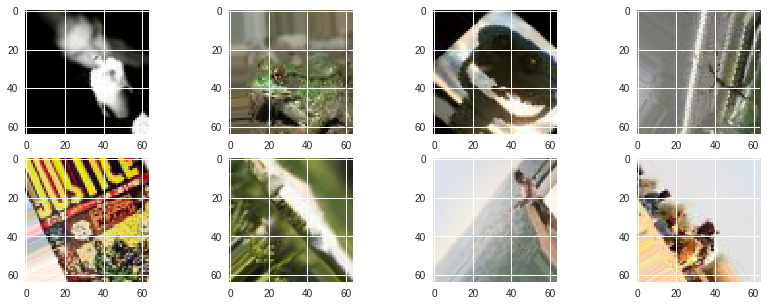

In [0]:
# Plot Generator images.

fig = plt.figure(figsize=(14, 5))

for i in range(8):
    sub = fig.add_subplot(2, 4, i + 1)
    sub.imshow(x_batch[i,:,:], interpolation='nearest')